In [ ]:
%pip install --upgrade typing_extensions

In [ ]:
%pip install torch
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install networkx
%pip install matplotlib
%pip install scikit-learn
%pip install torch-geometric

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import networkx as nx
import torch_geometric
import torch.optim as optim
import matplotlib.pyplot as plt

from numpy import random
from sklearn.dummy import DummyClassifier
from torch_geometric.datasets import TUDataset
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split

# Part I

### 1. Understanding the Data

(a) How many features and samples are present in the dataset?
    Number of samples: 900, number of features: 2
    Shape of labels: (900,)

Unique labels: [0. 1.], label counts: [500 400]

(b) Is the task a regression, binary classification, or multiclass classification?
    binary classification, because there are two unique labels (0 and 1)

(c) Plot a histogram of the label distribution. What does this distribution tell you?


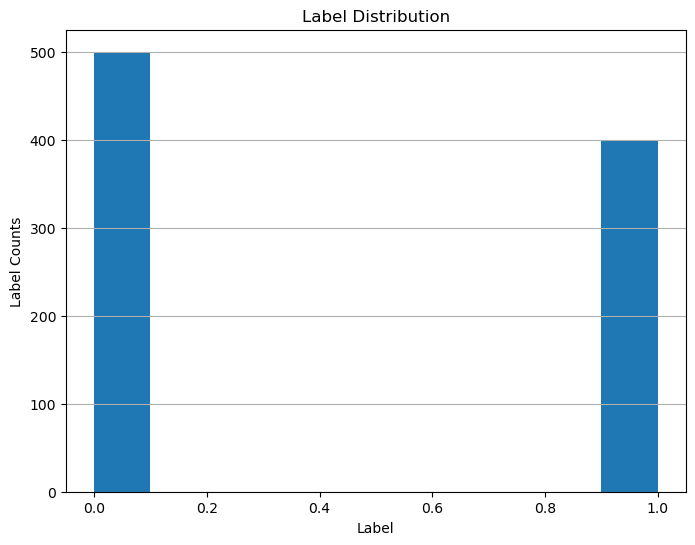

In [2]:
# Load the files features.npy and labels.npy
features = np.load("data/features.npy")
labels = np.load("data/labels.npy")

num_samples, num_features = features.shape
labels_shape = labels.shape
print("(a) How many features and samples are present in the dataset?")
print(f"    Number of samples: {num_samples}, number of features: {num_features}")
print(f"    Shape of labels: {labels_shape}")

unique_labels, label_counts = np.unique(labels, return_counts=True)
print(f"\nUnique labels: {unique_labels}, label counts: {label_counts}")

print("\n(b) Is the task a regression, binary classification, or multiclass classification?")
print("    binary classification, because there are two unique labels (0 and 1)")

print("\n(c) Plot a histogram of the label distribution. What does this distribution tell you?")

plt.figure(figsize=(8, 6))
plt.hist(labels)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Label Counts")
plt.grid(axis='y')
plt.show()



It looks like the label consist of zeroes and ones. From the histogram above, we see that there is 500 zeroes and 400 ones, which means zeroes come in the labels more frequent than ones.

### 2. Data visualisation

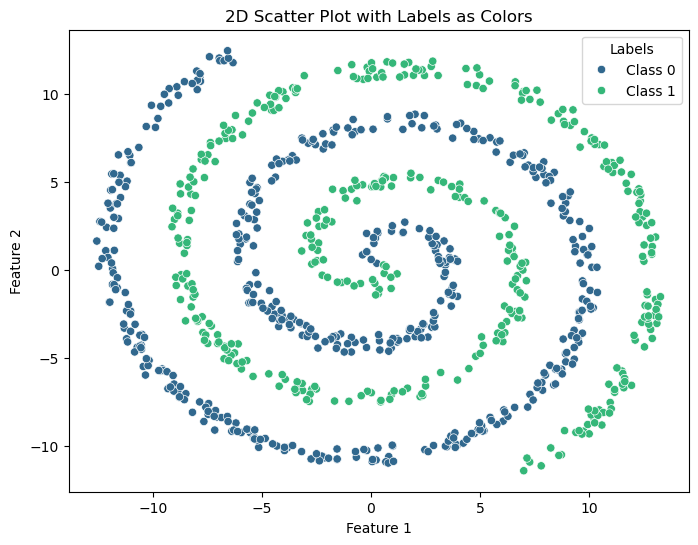

In [3]:
# Create a DataFrame for the features and labels
df = pd.DataFrame(features, columns=['x', 'y'])

# Map labels to class names
df['label'] = pd.Series(labels).map({0: 'Class 0', 1: 'Class 1'})

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend='full')
plt.title("2D Scatter Plot with Labels as Colors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Labels')
plt.show()


### 3. Fitting the first classifier

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
print(f"Logistic Regression model accuracy: {acc * 100:.2f}%")

Logistic Regression model accuracy: 64.44%


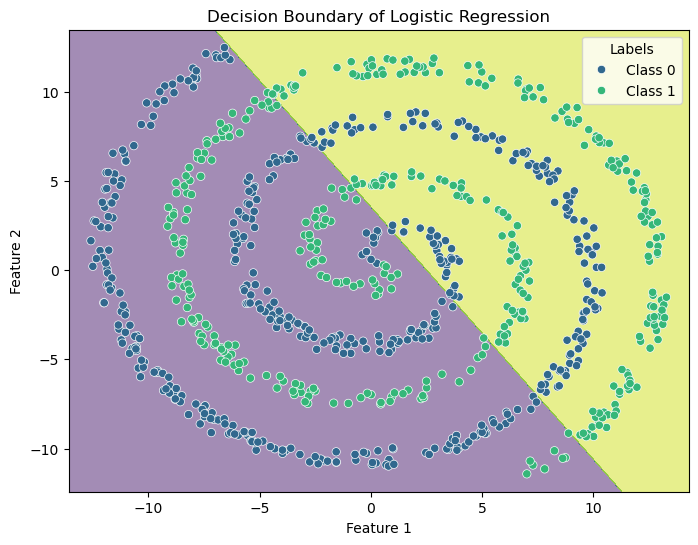

In [5]:
# Plot decision boundary
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict on the mesh grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend='full')
plt.title("Decision Boundary of Logistic Regression")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Labels')
plt.show()


### 4. Does the model perform better than chance?

##### (a) Shuffle the data one time

Due to using `np.random.permutation` instead of `np.random.shuffle`, we make sure, that the original data stay unchanged. So, with `np.random.permutation` we can shuffle the data and store them as a new shuffled data.

Additionally we use `np.random.seed(42)`  (42 is the most common random state) to make use the accuracy will reproduce always the same output every time we run the notebook.

In [6]:
random.seed(42)
shuffled_labels = random.permutation(y_test)
print(f"Accuracy after shuffling the data one time: {metrics.accuracy_score(y_test, shuffled_labels) * 100:.2f}%")

Accuracy after shuffling the data one time: 51.85%


##### (b) Shuffle the data 1000 times

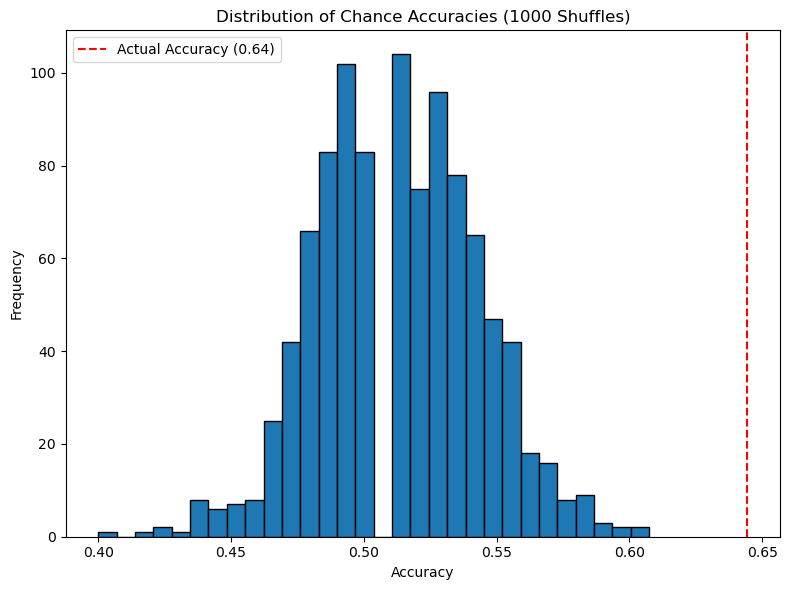

In [7]:
shuffled_accuracies = [metrics.accuracy_score(y_test, random.permutation(y_test)) for _ in range(1000)]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(shuffled_accuracies, bins=30, edgecolor='black')
plt.axvline(acc, color='red', linestyle='--', label=f'Actual Accuracy ({acc:.2f})')
plt.title("Distribution of Chance Accuracies (1000 Shuffles)")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

Let' compare the shuffled data with much less permutations (e.g. 100)

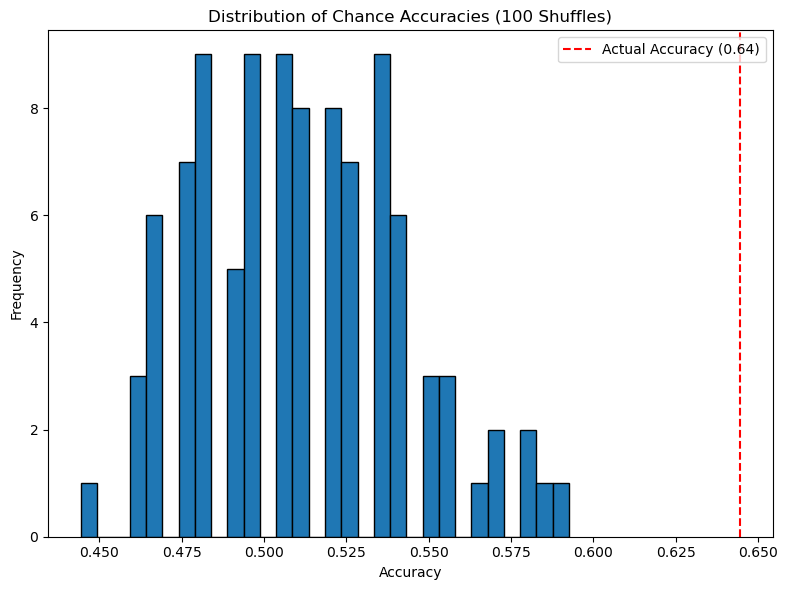

In [8]:
shuffled_accuracies_fewer = [metrics.accuracy_score(y_test, random.permutation(y_test)) for _ in range(100)]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(shuffled_accuracies_fewer, bins=30, edgecolor='black')
plt.axvline(acc, color='red', linestyle='--', label=f'Actual Accuracy ({acc:.2f})')
plt.title("Distribution of Chance Accuracies (100 Shuffles)")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

##### (e) Estimate the accuracy of a simple baseline classifier that always predicts the most frequent class

In [9]:
# Use dummy classifier to identify the most frequent class 
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
most_frequent_pred = most_frequent.predict(X_test)
print(f"The most frequent class accuracy: {metrics.accuracy_score(y_test, most_frequent_pred) * 100:.2f}%")

The most frequent class accuracy: 58.15%


### 5. Neural nets

##### (a) create a neural network architecture

In [10]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [37]:
#prepare the data
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Send tensors to the appropriate device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [47]:
# Define a simple neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)
        output = self.fc2(output)
        return output

# Instantiate model
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [48]:
# define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
train_acc = []
test_acc = []

epochs = 100 # number of epochs to run
for epoch in range(epochs):
    # Training
    model.train()

    # Forward pass
    y_logits = model(X_train_tensor).squeeze()
    
    # Calculate loss
    loss = loss_fn(y_logits, y_train_tensor)

    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.inference_mode():
        # Forward pass train
        train_logits = model(X_train_tensor).squeeze()
        train_pred = torch.round(torch.sigmoid(train_logits))
        
        # Forward pass tests
        test_logits = model(X_test_tensor).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))


        # Calculate accuracies and append to lists
        train_acc.append(metrics.accuracy_score(y_train_tensor.numpy(), train_pred.cpu().numpy()))
        test_acc.append(metrics.accuracy_score(y_test_tensor.numpy(), test_pred.cpu().numpy()))

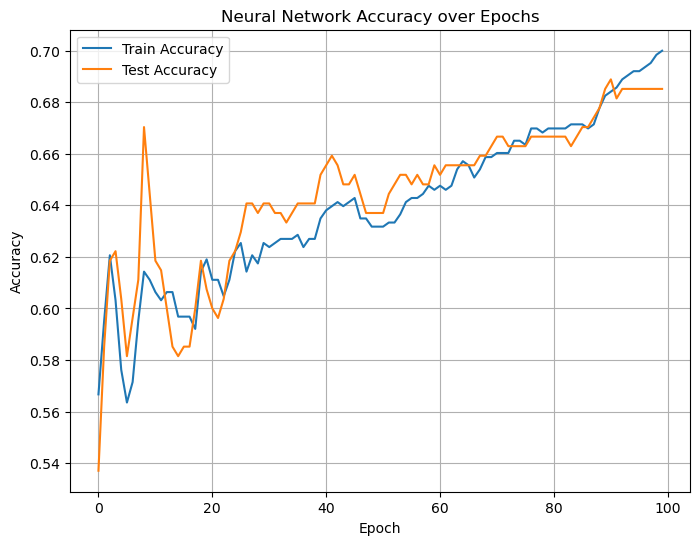

In [49]:
# Plot accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), test_acc, label='Test Accuracy')
plt.title("Neural Network Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

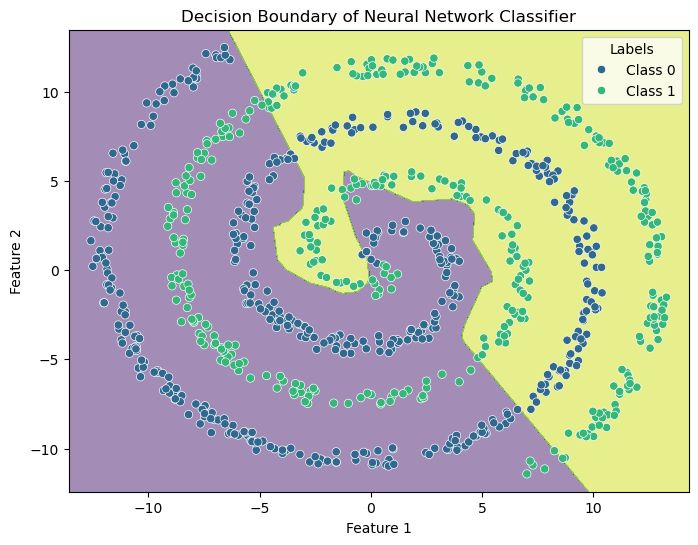

In [50]:
# Predict on the mesh grid
grid_tensor = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

# Predict with trained neural network model
model.eval()
with torch.inference_mode():
   logits = model(grid_tensor).squeeze()
   pred = torch.round(torch.sigmoid(logits))

   # Reshape the predictions to match the grid shape
   Z_pred = pred.reshape(xx.shape).detach().numpy()

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_pred, alpha=0.5, cmap='viridis')
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend='full')
plt.title("Decision Boundary of Neural Network Classifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Labels')
plt.show()


# Part II

### 1. Download the MUTAG dataset

In [16]:
# Download MUTAG from TUDatasets
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset.download()

print(f'Dataset size: {len(dataset)}')
print(f'First sample: {dataset[0]}')

Dataset size: 188
First sample: Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [17]:
# (a) Get dataset statistics
num_samples = len(dataset)  # Number of graphs
num_features = dataset.num_node_features  # Number of node features
num_classes = dataset.num_classes  # Number of target classes

print(f'Number of samples (graphs): {num_samples}')
print(f'Number of features per node: {num_features}')
print(f'Number of classes: {num_classes}')

Number of samples (graphs): 188
Number of features per node: 7
Number of classes: 2


In [18]:
# (c) Print the number of nodes and edges in the first graph
print(f'Number of nodes: {dataset[0].num_nodes}')
print(f'Number of edges: {dataset[0].num_edges}')

Number of nodes: 17
Number of edges: 38


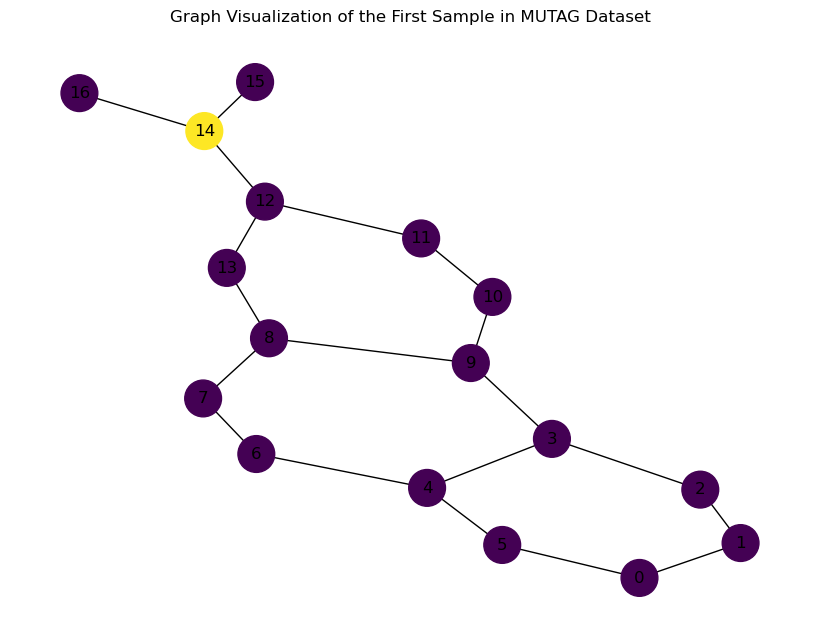

In [19]:
G = nx.Graph()
edge_index = dataset[0].edge_index.numpy().T
G.add_edges_from(edge_index)

node_colors = dataset[0].x[:, 1].numpy()

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, node_size=700)
plt.title("Graph Visualization of the First Sample in MUTAG Dataset")
plt.show()

### 2. Train and evaluate as in Part I

In [20]:
graph_features = []
graph_labels = []

for data in dataset:
    graph_feature = data.x.mean(dim=0)
    graph_features.append(graph_feature.numpy())
    
    graph_labels.append(int(data.y))

graph_features = np.stack(graph_features)
graph_labels = np.array(graph_labels)

print("Graph features shape:", graph_features.shape)
print("Graph labels shape:", graph_labels.shape)


Graph features shape: (188, 7)
Graph labels shape: (188,)


Logistic Regression Accuracy: 68.42%


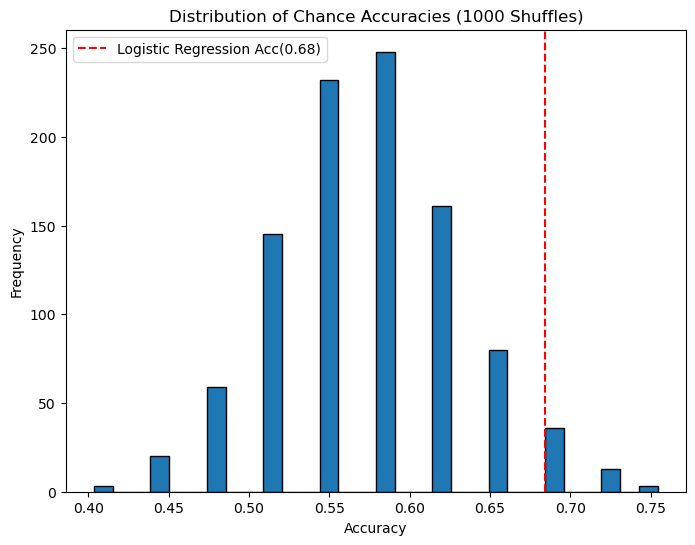

In [21]:
# Split into training and test sets
X_train_MUTAG, X_test_MUTAG, y_train_MUTAG, y_test_MUTAG = train_test_split(
    graph_features, graph_labels, test_size=0.3, random_state=42)

# Train a logistic regression (linear) model
model_MUTAG = LogisticRegression()
model_MUTAG.fit(X_train_MUTAG, y_train_MUTAG)

# Predict and evaluate
y_pred_MUTAG = model_MUTAG.predict(X_test_MUTAG)
acc_MUTAG = metrics.accuracy_score(y_test_MUTAG, y_pred_MUTAG)
print(f"Logistic Regression Accuracy: {acc_MUTAG * 100:.2f}%")

shuffled_accuracies_MUTAG = [metrics.accuracy_score(y_test_MUTAG, random.permutation(y_test_MUTAG)) for _ in range(1000)]

plt.figure(figsize=(8, 6))
plt.hist(shuffled_accuracies_MUTAG, bins=30, edgecolor='black')
plt.axvline(acc_MUTAG, color='red', linestyle='--', label=f"Logistic Regression Acc({acc_MUTAG:.2f})")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Distribution of Chance Accuracies (1000 Shuffles)")
plt.legend()
plt.show()


In [22]:
#prepare the data for MUTAG dataset
X_train_tensor_MUTAG = torch.from_numpy(X_train_MUTAG).float()
y_train_tensor_MUTAG = torch.from_numpy(y_train_MUTAG).float()
X_test_tensor_MUTAG = torch.from_numpy(X_test_MUTAG).float()
y_test_tensor_MUTAG = torch.from_numpy(y_test_MUTAG).float()

# Send tensors to the appropriate device
X_train_tensor_MUTAG = X_train_tensor_MUTAG.to(device)
y_train_tensor_MUTAG = y_train_tensor_MUTAG.to(device)
X_test_tensor_MUTAG = X_test_tensor_MUTAG.to(device)
y_test_tensor_MUTAG = y_test_tensor_MUTAG.to(device)

In [23]:
# Define a simple feedforward neural network
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)
        output = self.fc2(output)
        return output

input_dim = X_train_MUTAG.shape[1]
model_MUTAG = FeedforwardNeuralNetwork(input_dim=input_dim, hidden_dim=20, output_dim=1).to(device)
print(model_MUTAG)

FeedforwardNeuralNetwork(
  (fc1): Linear(in_features=7, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


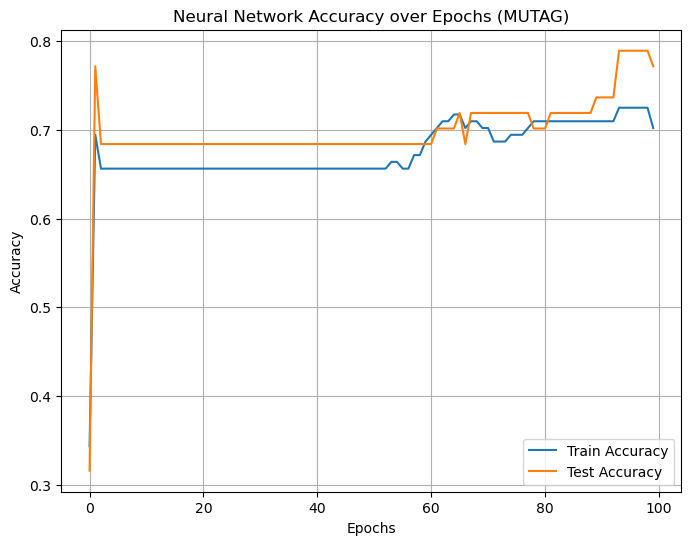

In [24]:
# Loss and optimizer
loss_fn_MUTAG = nn.BCEWithLogitsLoss()  # Combines sigmoid and BCE loss
optimizer_MUTAG = optim.Adam(model_MUTAG.parameters(), lr=0.01)

# Training loop
train_acc_MUTAG = []
test_acc_MUTAG = []

num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model_MUTAG.train()

    # Forward pass
    y_logits_MUTAG = model_MUTAG(X_train_tensor_MUTAG).squeeze()  # shape: (num_samples,)
    
    # Calculate loss
    loss_MUTAG = loss_fn_MUTAG(y_logits_MUTAG, y_train_tensor_MUTAG)

    # Optimizer zero grad
    optimizer_MUTAG.zero_grad()
    
    # Loss backwards
    loss_MUTAG.backward()

    # Optimizer step
    optimizer_MUTAG.step()
    
    # Evaluation
    model_MUTAG.eval()
    with torch.inference_mode():
        # Forward pass train
        train_logits_MUTAG = model_MUTAG(X_train_tensor_MUTAG).squeeze()
        train_pred_MUTAG = torch.round(torch.sigmoid(train_logits_MUTAG))
        
        test_logits_MUTAG = model_MUTAG(X_test_tensor_MUTAG).squeeze()
        test_pred_MUTAG = torch.round(torch.sigmoid(test_logits_MUTAG))
    
        # Calculate accuracies and append to lists
        train_acc_MUTAG.append(metrics.accuracy_score(y_train_tensor_MUTAG.numpy(), train_pred_MUTAG.cpu().numpy()))
        test_acc_MUTAG.append(metrics.accuracy_score(y_test_tensor_MUTAG.numpy(), test_pred_MUTAG.cpu().numpy()))

# Plot accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_acc_MUTAG, label='Train Accuracy')
plt.plot(range(num_epochs), test_acc_MUTAG, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Neural Network Accuracy over Epochs (MUTAG)")
plt.legend()
plt.grid(True)
plt.show()
